多因子期货

分钟线预测涨跌

In [6]:
import os
import sys
import glob
import pathlib
from copy import deepcopy
from collections import Counter
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import talib
from sklearn import preprocessing

In [37]:
""" 候选品种
TA0 czce    PTA连续
MA0	czce	甲醇连续
RM0	czce	菜粕连续
C0  dce     玉米连续
"""
import akshare as ak

ta_df = ak.futures_zh_minute_sina(symbol="TA2201", period="15")
print(ta_df.shape)
ta_df.head()

(1023, 7)


,datetime,open,high,low,close,volume,hold
0,2021-11-11 14:15:00,5016.0,5026.0,5014.0,5020.0,34474,1047491
1,2021-11-11 14:30:00,5022.0,5022.0,5010.0,5010.0,24191,1052735
2,2021-11-11 14:45:00,5010.0,5012.0,5004.0,5008.0,45614,1050071
3,2021-11-11 15:00:00,5010.0,5014.0,5002.0,5014.0,51467,1046447
4,2021-11-11 21:15:00,4992.0,5010.0,4980.0,5000.0,155800,1055519


In [38]:
ta_df.shape

(1023, 7)

In [39]:
ta_df.head()

,datetime,open,high,low,close,volume,hold
0,2021-11-11 14:15:00,5016.0,5026.0,5014.0,5020.0,34474,1047491
1,2021-11-11 14:30:00,5022.0,5022.0,5010.0,5010.0,24191,1052735
2,2021-11-11 14:45:00,5010.0,5012.0,5004.0,5008.0,45614,1050071
3,2021-11-11 15:00:00,5010.0,5014.0,5002.0,5014.0,51467,1046447
4,2021-11-11 21:15:00,4992.0,5010.0,4980.0,5000.0,155800,1055519


## feature

In [73]:
FUTURE = 5
TASK = "clf"

def get_ma_feature(df):
    periods = np.arange(3,25)
    for i in periods:
        # df[f"ma{i}"] = talib.SMA(df["close"], timeperiod=i)
        ma = talib.EMA(df["close"], timeperiod=i)
        # df[f"kama{i}"] = talib.KAMA(df["close"], timeperiod=i)
        # df[f"open_ma{i}"] = talib.EMA(df["open"], timeperiod=i)
        df[f"ma{i}_close"] = ma - df["close"]
        
    # combines = combinations(periods, 2)
    # for i in combines:
    #     if i[0] < i[1]:
    #         df[f"ma{i[0]}-{i[1]}"] = df[f"ma{i[0]}"] - df[f"ma{i[1]}"]
            
def get_add_feature(df):
    low, high, close = df["low"], df["high"], df["close"]

    # Support and resistance
    periods = np.arange(3,25)
    for i in periods:
        df[f"support_{i}"] = df["close"].rolling(window=i).min() - df["close"]
        df[f"resistance_{i}"] = df["close"].rolling(window=i).max() - df["close"]
        df[f"shock_{i}"] = df["close"].rolling(window=i).std() - df["close"]
        
        df[f"up_count_{i}"] = (df["close"] - df["close"].shift(1)).apply(lambda x:1 if x>0 else 0)\
        .rolling(window=i).apply(lambda x:Counter(x)[1]) / i
        
        df[f"momentum_{i}"] = df["close"] / df["close"].shift(i) - 1


def get_label(close, avg_close, std_close):
    if (avg_close > close+std_close):
        return 1
    elif (avg_close < close-std_close):
        return 0
    else:
        return 2

def get_feature_df(df):
    df = deepcopy(df)
        
    assert TASK in ("clf","reg")
    # calculate up/down
    if TASK=="clf":
        window = FUTURE
        avg_close = df["close"].rolling(window=window).mean().shift(-window)
        # std_close = df["close"].rolling(window=window).std().shift(-window)
        # future_df = pd.concat([df["close"], avg_close, std_close], axis=1)
        # future_df.columns = ["close","avg_close","std_close"]
        # df["label"] = future_df.apply(lambda x: get_label(x.close,x.avg_close,x.std_close), axis=1)
        df["label"] = (avg_close - df["close"]).apply(lambda x: 1 if x>0 else 0)
    if TASK=="reg":
        df["label"] = close_change
    
    # calculate factor
    get_ma_feature(df)
    get_add_feature(df)
    
    # drop anomaly value
    df = df.dropna().reset_index(drop=True)
    df = df.drop(0, axis=0).reset_index(drop=True)
    df = df.drop([len(df)-1], axis=0).reset_index(drop=True)
    return df

def get_feature_label(df):
    feature_df = df.drop(["datetime","open","high","low","close","volume","hold","label"],axis=1)
    # feature_df = (feature_df-feature_df.min())/(feature_df.max()-feature_df.min())
    feature_df = (feature_df-feature_df.mean())/(feature_df.std())
    features = feature_df.values
    labels = df["label"].values
    return features, labels

In [74]:
get_feature_df(ta_df).head()

,datetime,open,high,low,close,volume,hold,label,ma3_close,ma4_close,...,support_23,resistance_23,shock_23,up_count_23,momentum_23,support_24,resistance_24,shock_24,up_count_24,momentum_24
0,2021-11-12 14:45:00,4990.0,5000.0,4986.0,4994.0,27234,1049279,0,0.834992,1.533070,...,-12.0,32.0,-4982.416995,0.521739,-0.002796,-12.0,32.0,-4982.648246,0.500000,-0.003194
1,2021-11-12 15:00:00,4994.0,5004.0,4994.0,4998.0,42782,1040233,0,-1.582504,-1.480158,...,-16.0,28.0,-4986.537740,0.521739,-0.003191,-16.0,28.0,-4986.595704,0.541667,-0.001997
2,2021-11-12 21:15:00,4960.0,4984.0,4944.0,4974.0,154382,1048472,0,11.208748,13.511905,...,0.0,52.0,-4960.976458,0.521739,-0.005200,0.0,52.0,-4961.251599,0.500000,-0.007978
3,2021-11-12 21:30:00,4976.0,5006.0,4976.0,4994.0,87234,1048426,0,-4.395626,-3.892857,...,-20.0,32.0,-4981.614876,0.565217,0.002409,-20.0,32.0,-4981.142081,0.541667,-0.001200
4,2021-11-12 21:45:00,4996.0,5000.0,4974.0,4980.0,44989,1051284,0,4.802187,6.064286,...,-6.0,46.0,-4966.826785,0.521739,-0.002803,-6.0,46.0,-4966.999443,0.541667,-0.000401


In [66]:
df.tail()

,datetime,open,high,low,close,volume,hold
1018,2022-01-17 14:00:00,5242.0,5242.0,5242.0,5242.0,1,19062
1019,2022-01-17 14:15:00,5258.0,5258.0,5258.0,5258.0,1,19062
1020,2022-01-17 14:30:00,5258.0,5258.0,5258.0,5258.0,1,19062
1021,2022-01-17 14:45:00,5260.0,5260.0,5260.0,5260.0,1,19062
1022,2022-01-17 15:00:00,5260.0,5278.0,5260.0,5278.0,2,19062


## classification

In [75]:
FUTURE = 10
TASK = "clf"

In [76]:
train_X, train_Y, valid_X, valid_Y, test_X, test_Y = [],[],[],[],[],[]

# df = dfs["TA0.czce"]
df = ta_df
# df = get_feature_df(df)
train_df = df[df["datetime"] < '2022-01-10'].reset_index(drop=True)
valid_df = df[(df["datetime"] > "2022-01-10") & (df["datetime"] < "2022-02-01")].reset_index(drop=True)
test_df = df[df["datetime"] > "2022-01-01"].reset_index(drop=True)

train_data = get_feature_label(get_feature_df(train_df))
valid_data = get_feature_label(get_feature_df(valid_df))
test_data = get_feature_label(get_feature_df(test_df))

print(len(train_data[0]), len(valid_data[0]), len(test_data[0]), train_data[0].shape)

885 86 165 (885, 132)


### fit

In [70]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, accuracy_score

In [77]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(train_data[0], train_data[1])
# clf.predict(valid_data[0]), valid_data[1]

y_true, y_pred = train_data[1], clf.predict(train_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
accuracy_score(clf.predict(train_data[0]), train_data[1])


[[233 183]
 [132 337]]
              precision    recall  f1-score   support

           0       0.64      0.56      0.60       416
           1       0.65      0.72      0.68       469

    accuracy                           0.64       885
   macro avg       0.64      0.64      0.64       885
weighted avg       0.64      0.64      0.64       885



0.6440677966101694

In [78]:

y_true, y_pred = valid_data[1], clf.predict(valid_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
accuracy_score(clf.predict(valid_data[0]), valid_data[1])

[[17 27]
 [21 21]]
              precision    recall  f1-score   support

           0       0.45      0.39      0.41        44
           1       0.44      0.50      0.47        42

    accuracy                           0.44        86
   macro avg       0.44      0.44      0.44        86
weighted avg       0.44      0.44      0.44        86



0.4418604651162791

In [62]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,max_depth=3, random_state=0)
clf.fit(train_data[0], train_data[1])

y_true, y_pred = train_data[1], clf.predict(train_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
accuracy_score(clf.predict(train_data[0]), train_data[1])


[[ 47   0 170]
 [  3  26 253]
 [  2   0 385]]
              precision    recall  f1-score   support

           0       0.90      0.22      0.35       217
           1       1.00      0.09      0.17       282
           2       0.48      0.99      0.64       387

    accuracy                           0.52       886
   macro avg       0.79      0.43      0.39       886
weighted avg       0.75      0.52      0.42       886



0.5169300225733634

In [63]:
y_true, y_pred = valid_data[1], clf.predict(valid_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
accuracy_score(clf.predict(valid_data[0]), valid_data[1])

[[ 1  0 16]
 [ 0  5 23]
 [ 1  1 40]]
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        17
           1       0.83      0.18      0.29        28
           2       0.51      0.95      0.66        42

    accuracy                           0.53        87
   macro avg       0.61      0.40      0.35        87
weighted avg       0.61      0.53      0.43        87



0.5287356321839081

In [29]:
import xgboost as xgb

clf = xgb.XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.1)
clf.fit(train_data[0], train_data[1])

y_true, y_pred = train_data[1], clf.predict(train_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
accuracy_score(clf.predict(train_data[0]), train_data[1])


[[222  80]
 [ 29 327]]
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       302
           1       0.80      0.92      0.86       356

    accuracy                           0.83       658
   macro avg       0.84      0.83      0.83       658
weighted avg       0.84      0.83      0.83       658



0.8343465045592705

In [30]:

y_true, y_pred = valid_data[1], clf.predict(valid_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
accuracy_score(clf.predict(valid_data[0]), valid_data[1])

[[ 58 111]
 [ 45 101]]
              precision    recall  f1-score   support

           0       0.56      0.34      0.43       169
           1       0.48      0.69      0.56       146

    accuracy                           0.50       315
   macro avg       0.52      0.52      0.50       315
weighted avg       0.52      0.50      0.49       315



0.5047619047619047

In [286]:
import pickle
with open("D:/quant/checkpoint/clf_ta.pickle","wb") as f:
    pickle.dump(clf, f)

In [15]:
clf.predict(valid_data[0])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1], dtype=int64)

In [16]:
valid_data[1]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0], dtype=int64)

## regression

In [450]:
TASK = "reg"

In [451]:
train_X, train_Y, valid_X, valid_Y, test_X, test_Y = [],[],[],[],[],[]

df = dfs["MA0.czce"]
# df = get_feature_df(df)
train_df = df[df["datetime"] < '2021-07-01'].reset_index(drop=True)
valid_df = df[(df["datetime"] > "2021-07-01") & (df["datetime"] < "2022-01-01")].reset_index(drop=True)
test_df = df[df["datetime"] > "2022-01-01"].reset_index(drop=True)

train_data = get_feature_label(get_feature_df(train_df))
valid_data = get_feature_label(get_feature_df(valid_df))
test_data = get_feature_label(get_feature_df(test_df))

print(len(train_data[0]), len(valid_data[0]), len(test_data[0]), train_data[0].shape)

1544 89 104 (1544, 57)


In [452]:
from sklearn.metrics import mean_squared_error

In [453]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_data[0], train_data[1])
reg.predict(valid_data[0])
mean_squared_error(valid_data[1], reg.predict(valid_data[0]))

64.91751462398756

In [454]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(max_depth=6, random_state=0)
rf_reg.fit(train_data[0], train_data[1])
rf_reg.predict(valid_data[0])
mean_squared_error(valid_data[1], rf_reg.predict(valid_data[0]))

7.890115664766683

## plot

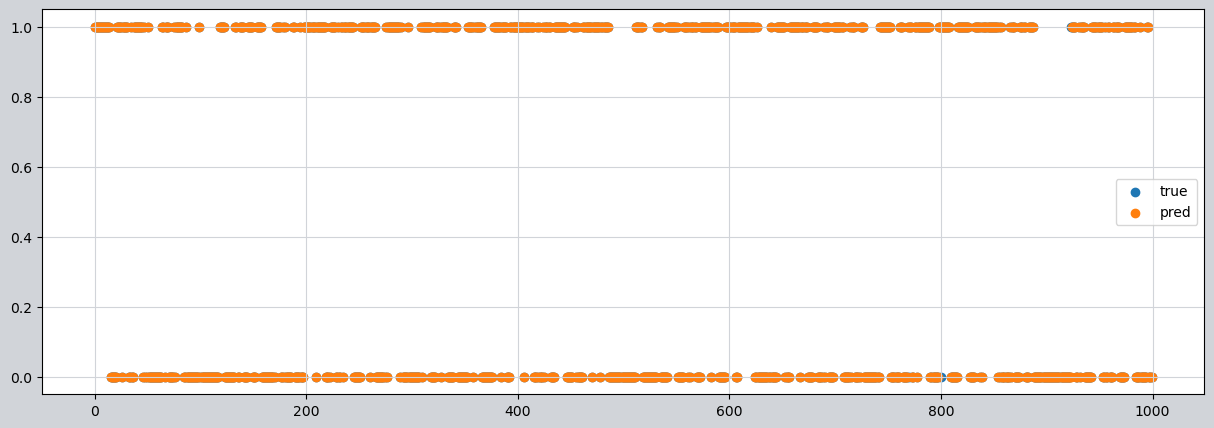

0.003


In [1057]:
import matplotlib.pyplot as plt

def evaluate(model, data, label):
    fig = plt.figure(figsize = (15,5))
    # plt.plot(label, label="true")
    plt.scatter(range(len(label)), label, label="true")
    preds = model.predict(data)
    # plt.plot(preds, label="pred")
    plt.scatter(range(len(preds)), preds, label="pred")
    plt.legend()
    plt.show()
    
    print(np.mean((preds - label)**2))

evaluate(clf, train_data[0][:1000], train_data[1][:1000])

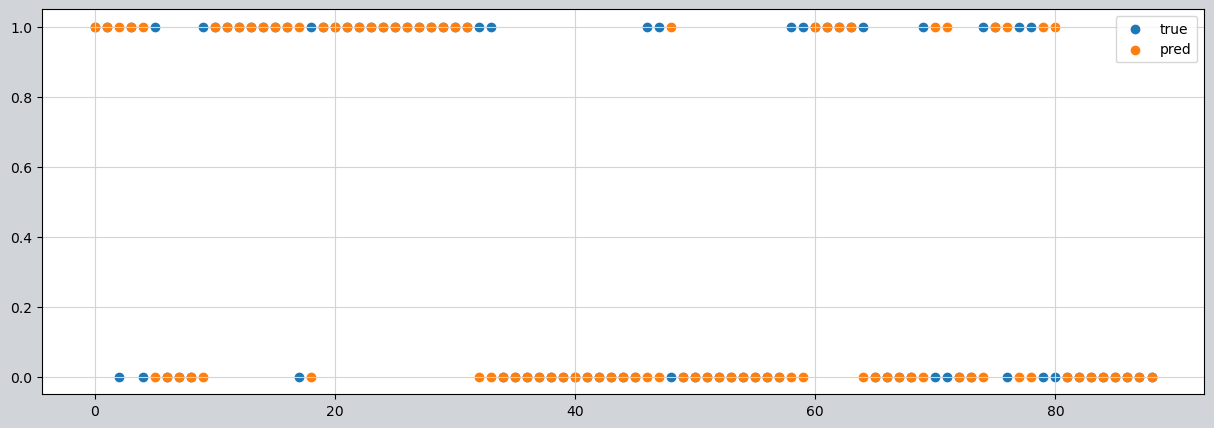

0.25842696629213485


In [1058]:
evaluate(clf, valid_data[0], valid_data[1])

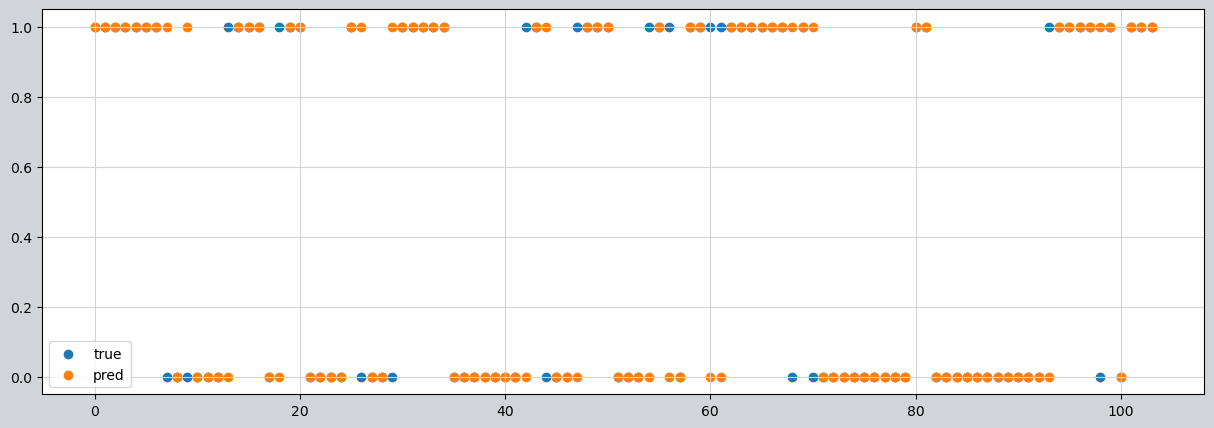

0.16346153846153846


In [1119]:
evaluate(clf, test_data[0], test_data[1])

## plot buy/sell

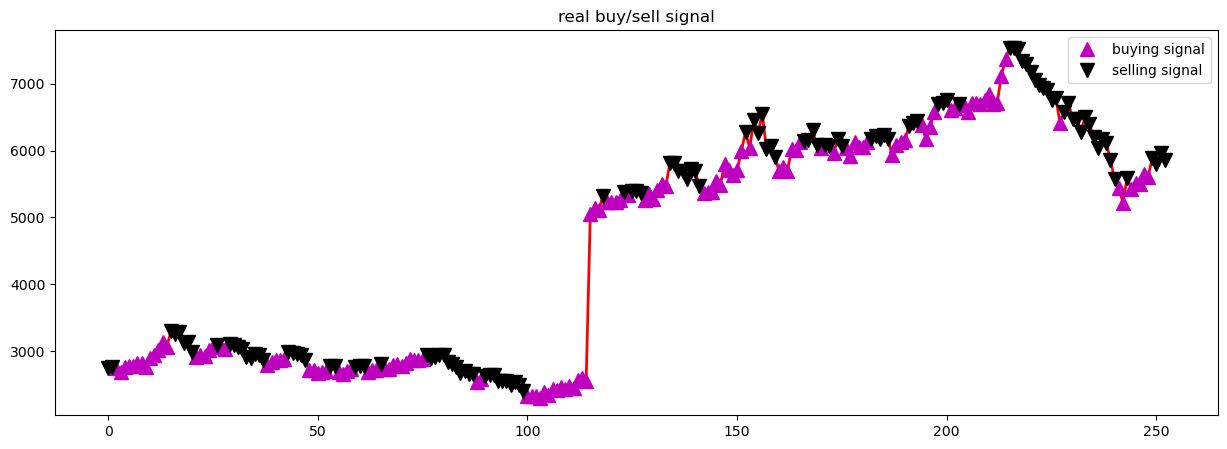

In [38]:
import matplotlib.pyplot as plt

FUTURE = 5

analyse_df = get_feature_df(test_df)

states_buy, states_sell = [],[]
for i in range(len(analyse_df)):
    if analyse_df.loc[i,"label"] == 1:
        states_buy.append(i)
    else:
        states_sell.append(i)
        
close = analyse_df['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('real buy/sell signal')
plt.legend()
plt.show()

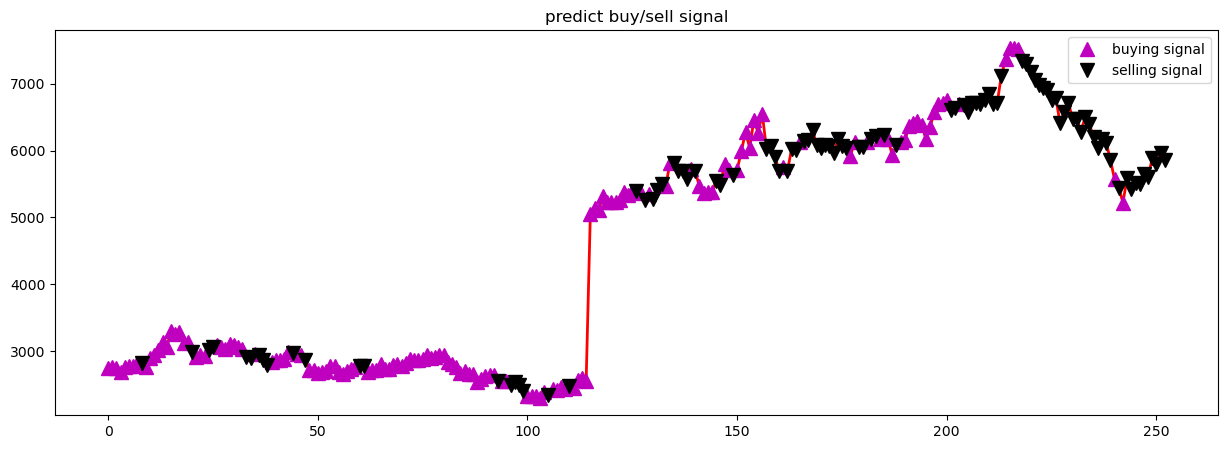

In [39]:
analyse_df = get_feature_df(test_df)

features, labels = get_feature_label(analyse_df)
preds = clf.predict_proba(features)[:,1]

states_buy, states_sell = [],[]
for i in range(len(features)):
    if preds[i] > 0.5:
        states_buy.append(i)
    elif preds[i] < 0.5:
        states_sell.append(i)
        
close = analyse_df['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('predict buy/sell signal')
plt.legend()
plt.show()

In [112]:
for col in analyse_df.columns[1:]:
    print(f"label -> {col}:", analyse_df.label.corr(analyse_df[col]))

label -> open: -0.2517573014704094
label -> high: -0.2520370539795085
label -> low: -0.24350035593784805
label -> close: -0.24856394258211545
label -> volume: -0.11098627364778779
label -> label: 1.0
label -> ma3: -0.26009271833889813
label -> ma3_close: -0.031065141098889006
label -> ma5: -0.24996488844589812
label -> ma5_close: 0.017378338659659435
label -> ma8: -0.220353288227354
label -> ma8_close: 0.08342037161146418
label -> ma10: -0.19536149629295718
label -> ma10_close: 0.12439686823937182
label -> ma15: -0.1834910919425158
label -> ma15_close: 0.12842030325292586
label -> ma20: -0.21810923041508368
label -> ma20_close: 0.06969088928716245
label -> ma3-5: -0.07807430082735245
label -> ma3-8: -0.13987696769731936
label -> ma3-10: -0.17854225943720348
label -> ma3-15: -0.16360067903605788
label -> ma3-20: -0.08947802929745072
label -> ma5-8: -0.16728893778560253
label -> ma5-10: -0.20543256686488504
label -> ma5-15: -0.1676068638880558
label -> ma5-20: -0.07894664310293001
label 